In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pandas as pd

### Import from Harald to deal with Folder Structure
import socket
import os as os
import sys as sys
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name[:7] == "midway2":
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

VioletQueen
/home/harald/git/HAPSBURG
CPU Count: 4


In [2]:
def sloppyROH(recoMap, target, refHaps, windowSize = 0.001):
    """Figure out per snp agreement between references and reads from target
    how many reads agree with reference alleles?"""
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    numSnps = np.shape(target)[1]
    
    # make a dict that tells you which SNPs fall in a window around the focal SNP
    neighborhood = {}
    for p in range(numSnps):
        # debug print
#         if (p % 10000 == 0):
#             print (p)
        # the map relative to snp p
        relativeMap = recoMap - recoMap[p]
        # the indices of the snps that are in the window around p
        themIndices = numpy.nonzero(abs(relativeMap) < windowSize)
        neighborhood[p] = themIndices
    
    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    myROH = numpy.zeros(numSnps)
    for p in range(numSnps):
        # debug print
#         if (p % 10000 == 0):
#             print (p)
        # get your window
        daHood = neighborhood[p]
        # total number of reads in this window
        totalReads = numpy.sum(countsPerSnp[daHood])
        # get the agreement with ref haps in this window
        neighborAgreePerSnp = totalAgree[:,daHood]
        # total agreement with each ref hap in this window
        totalNeighborAgree = numpy.sum (neighborAgreePerSnp, axis=2)
        # relative to count number in window
        relativeNeighborAgree = totalNeighborAgree / totalReads
        # and store the max
        myROH[p] = numpy.max(relativeNeighborAgree)
        
    # give it away now
    return myROH

In [22]:
def sloppyROHToo (recoMap, target, refHaps, windowSize = 0.001):
    """Figure out per snp agreement between references and reads from target
    Hhow many reads agree with reference alleles?"""
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    # what are the bounds of the window around the focal SNP
    firstNeighbor = numpy.searchsorted (recoMap + windowSize, recoMap)
    lastNeighbor = numpy.searchsorted (recoMap - windowSize, recoMap)

    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    numSnps = np.shape(target)[1]
    myROH = numpy.zeros(numSnps)
    for p in range(numSnps):
        # debug print
#         if (p % 10000 == 0):
#             print (p)
        # get your window
        begin = firstNeighbor[p]
        end = lastNeighbor[p]
        # total number of reads in this window
        totalReads = numpy.sum(countsPerSnp[begin:end])
        # get the agreement with ref haps in this window
        neighborAgreePerSnp = totalAgree[:,begin:end]
        # total agreement with each ref hap in this window
        totalNeighborAgree = numpy.sum (neighborAgreePerSnp, axis=1)
        # relative to count number in window
        relativeNeighborAgree = totalNeighborAgree / totalReads
        # and store the max
        myROH[p] = numpy.max (relativeNeighborAgree)
        
    # give it away now
    return myROH

In [3]:
def collectWindow(begin, end, totalAgree, countsPerSnp):
    """Collect average agreement rate in totalAgree from begin to end.
    coutsPerSNP: The Count of every SNP"""
    totalReads = np.sum(countsPerSnp[begin:end])
    # get the agreement with ref haps in this window
    totalNeighborAgree = np.sum(totalAgree[:,begin:end], axis=1)
    # return max of agreement relative to count number in window
    return (np.max(totalNeighborAgree / totalReads))

In [4]:
def sloppyROHThree (recoMap, target, refHaps, windowSize = 0.001):
    """Figure out per SNP agreement between references and reads from target
    how many reads agree with reference alleles?"""
    ### Asses how many reads agree with ref and alternative alleles?
    refAgree = (1 - refHaps) * target[0,:]
    altAgree = refHaps * target[1,:]
    totalAgree = refAgree + altAgree     # Total Agreement at each SNP
    
    # what are the bounds of the window around the focal SNP
    firstNeighbor = np.searchsorted(recoMap + windowSize, recoMap)
    lastNeighbor = np.searchsorted(recoMap - windowSize, recoMap)

    # need total counts for each SNP to normalize
    countsPerSnp = np.sum(target, axis=0)
    
    # compute the number for every snp using the neighborhoods
    myROH = np.array([collectWindow(x, y, totalAgree, countsPerSnp) for (x,y) in zip(firstNeighbor, lastNeighbor)])
    
    return myROH

In [5]:
# vectorized version of collect window
# be sure to exlcude all but first two arguments
vecCollectWindow = numpy.vectorize(collectWindow, excluded=[2,3])

In [6]:
def sloppyROHFour (recoMap, target, refHaps, windowSize = 0.001):
    """Figure out per snp agreement between references and reads from target
    # how many reads agree with reference alleles?"""
    refAgree = (1-refHaps) * target[0,:]
    # how many reads agree with alternative alleles?
    altAgree = refHaps * target[1,:]
    # the total agreement at each SNP
    totalAgree = refAgree + altAgree
    
    # what are the bounds of the window around the focal SNP
    firstNeighbor = numpy.searchsorted (recoMap + windowSize, recoMap)
    lastNeighbor = numpy.searchsorted (recoMap - windowSize, recoMap)

    # need total counts per snp too normalize
    countsPerSnp = numpy.sum (target, axis=0)
    
    # now compute the number for every snp using the neighborhoods
    myROH = vecCollectWindow (firstNeighbor, lastNeighbor, totalAgree, countsPerSnp)
    
    # give it away now
    return myROH

In [2]:
def sloppyROH_cumsum(recoMap, target, refHaps, windowSize = 0.001):
    """
    Figure out per snp agreement between references and reads from target
    Return Max. fraction of reads agreeing with Ref Panel
    windowsize: Extension to each side [in cM]
    """
    #n_snps = len(recoMap)
    # Calculate total Nr of Mismatches for all ref
    refAgree = (1-refHaps) * target[0,:]
    altAgree = refHaps * target[1,:]
    totalAgree = refAgree + altAgree
    
    ### what are the bounds of the window around the focal SNP
    firstNeighbor = np.searchsorted(recoMap + windowSize, recoMap)
    lastNeighbor = np.searchsorted(recoMap - windowSize, recoMap)
    lastNeighbor = np.clip(lastNeighbor, a_min=None, a_max=len(recoMap)-1) # To avoid the overshooting the last Index
    
    countsPerSnp = np.sum(target, axis=0)       # Calculate total counts per snp for normalization
    
    totalAgree_cum = np.cumsum(totalAgree, axis=1)
    pad_zeros = np.zeros((np.shape(totalAgree)[0], 1)) # To add 0s at beginning of first axis
    totalAgree_cum = np.concatenate([pad_zeros, totalAgree_cum], axis=1) 
    countsPerSnp_cum = np.r_[0, np.cumsum(countsPerSnp)] # Add 0 in beginning
    
    totalAgree_window = totalAgree_cum[:, lastNeighbor] - totalAgree_cum[:, firstNeighbor]
    countsPerSnp_window = countsPerSnp_cum[lastNeighbor] - countsPerSnp_cum[firstNeighbor]
    
    agree_rate_window = totalAgree_window / countsPerSnp_window    # Average Agree Rate per Window
    max_agree_rate_window = np.max(agree_rate_window, axis=0)   # For the "best" Ref Haplotype
    return max_agree_rate_window

## Load the Data

### Load for Matthias

In [8]:
# read in posterior
posterior = np.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/posterior0.csv")
# load some files maybe
# recombination map (in morgan)
recoMap = np.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/map.csv", delimiter=',')
print (recoMap.shape)
# readcounts for target individual
# first line: reads for ref; second line: reads for alt
target = np.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/readcounts.csv", delimiter=',')
print (target.shape)
numSnps = target.shape[1]
# read in references
refHaps = numpy.loadtxt ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/refs.csv", delimiter=',')
print (refHaps.shape)

### General Loading Function

In [3]:
def load_data(basepath):
    """Load relevant data from folder basepath.
    Return posterior, recomap, target and reference haplotype"""

    ### Load all Data
    posterior = np.loadtxt(basepath + "posterior0.csv")
    recoMap = np.loadtxt(basepath + "map.csv", delimiter=',')
    target = np.loadtxt(basepath + "readcounts.csv", delimiter=',')
    refHaps = np.loadtxt(basepath + "refs.csv", delimiter=',')
    
    ### Sanity Checks
    numSnps = target.shape[1]
    assert(len(posterior) == numSnps)
    assert(len(recoMap) == numSnps)
    assert(np.shape(refHaps)[1]==numSnps)
    
    return posterior, recoMap, target, refHaps

In [4]:
%%time
basepath = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_4cm/output/iid0/chr3/data_matthias/"
posterior, recoMap, target, refHaps = load_data(basepath)
print(np.shape(refHaps))

(792, 38032)
CPU times: user 10.5 s, sys: 424 ms, total: 10.9 s
Wall time: 10.9 s


## Run the Tests

In [25]:
%%time
myRoh = sloppyROH(recoMap, target, refHaps)

CPU times: user 6.83 s, sys: 452 ms, total: 7.28 s
Wall time: 7.28 s


In [118]:
%%time
myRohToo = sloppyROHToo(recoMap, target, refHaps)

CPU times: user 2.55 s, sys: 444 ms, total: 2.99 s
Wall time: 2.99 s


In [116]:
%%time
myRohThree = sloppyROHThree(recoMap, target, refHaps)

CPU times: user 2.53 s, sys: 452 ms, total: 2.98 s
Wall time: 2.98 s


In [117]:
%%time
myRohFour = sloppyROHFour(recoMap, target, refHaps)

CPU times: user 2.63 s, sys: 451 ms, total: 3.08 s
Wall time: 3.09 s


In [8]:
%%time
myRoh_cumsum = sloppyROH_cumsum(recoMap, target, refHaps)

CPU times: user 646 ms, sys: 756 ms, total: 1.4 s
Wall time: 1.41 s


In [9]:
myRoh_cumsum[:10]

array([0.93055556, 0.93055556, 0.91780822, 0.92105263, 0.92105263,
       0.92105263, 0.92105263, 0.92105263, 0.92207792, 0.92207792])

In [113]:
### Sanity Check
np.max(np.abs(myRoh_cumsum - myRohFour))

0.006349206349206327

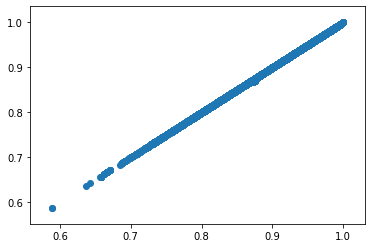

In [126]:
plt.scatter(myRohFour, myRoh_cumsum)
plt.show()

In [13]:
def plot_roh(target, myRoh, N=40, figsize=(16,4), darange=(5000,8000), savepath="", fs=12):
    # where do the observed reads show heterozygosity?
    hets = (target[0,:]>0) * (target[1,:]>0)
    # smooth it a bit (careful, this does not really use the genetic map)
    smoothHets = np.convolve(hets, np.ones(N) / N, mode='same')
    
    daRange = np.arange(darange[0], darange[1]) # For the x axis
    
    myRoh = myRoh[daRange]
    #myRoh = (myRoh - np.min(myRoh)) * 1 / (np.max(myRoh) - np.min(myRoh))  # Normalize

    plt.figure(figsize=figsize)
    plt.plot(recoMap[daRange]*100, (hets[daRange]-0.05)*1.1, "o", ms=2, label="Heterozgyotes Up", color="blue")
    plt.plot(recoMap[daRange]*100, myRoh, label="Best Local Match Rate", color="red")
    plt.plot(recoMap[daRange]*100, 1 - np.exp(posterior[daRange]), label="HAPSBURG Posterior")
    #plt.plot(recoMap[daRange]*100, 1 - smoothHets[daRange], label="Smoothed Heterozygotes", lw=2)
    plt.plot(recoMap[daRange]*100, myRoh >0.99, label="Cutoff BLMR: 0.99", lw=2, color="green")
    
    plt.legend(loc="center left", fontsize=fs)
    # plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange])>0.8, recoMap[daRange]*100, (myRoh > th)[daRange])
    # plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange])>0.8, recoMap[daRange]*100, (myRoh > th)[daRange], recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o")
    # plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange])>0.8, recoMap[daRange]*100, (myRoh > th)[daRange])
    plt.xlabel("cM")
    plt.show()

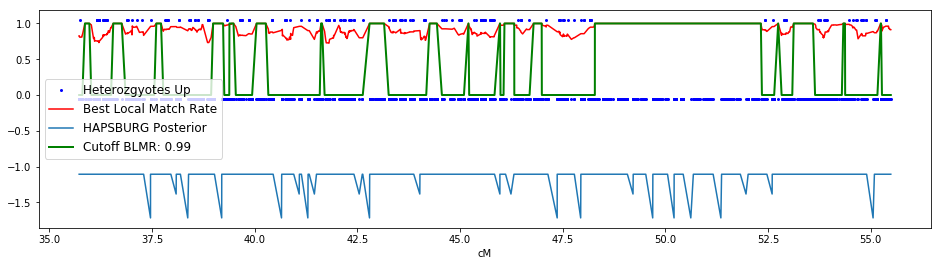

In [14]:
plot_roh(target, myRoh_cumsum, darange=(5000, 8000))

In [22]:
# get some truth
truthTable = pandas.read_csv ("/Users/steinrue/tmp/haraldHAPSBURG/data_matthias/roh_gt.csv", sep='\t')

In [23]:
truthTable

,ROH_Begin,ROH_End,iid,copyiid,chr
0,0.002675,0.042675,iid0,NA20797,3
1,0.481866,0.521866,iid0,NA20778,3
2,1.078672,1.118672,iid0,NA20797,3
3,1.676946,1.716946,iid0,NA20509,3
4,2.074746,2.114746,iid0,NA20772,3


In [24]:
# make a truth vector
truth = numpy.zeros (numSnps)
beginnings = numpy.searchsorted (recoMap, truthTable["ROH_Begin"])
ends = numpy.searchsorted (recoMap, truthTable["ROH_End"])
assert (len(beginnings) == len(ends))
for i in range(len(beginnings)):
    truth [beginnings[i]:ends[i]] = 1

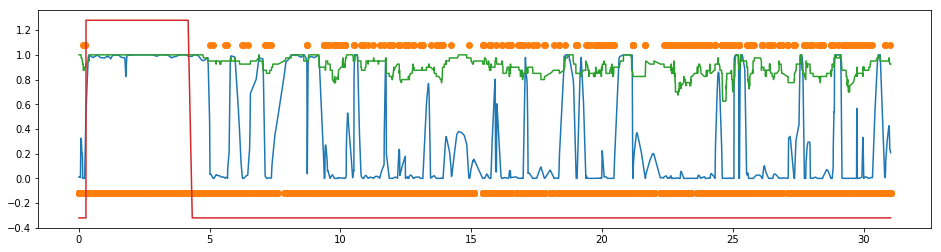

In [25]:
daRange = numpy.arange(0,4000)
plt.figure (figsize=(16,4))
plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange]),
          recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o",
          recoMap[daRange]*100, 1-smoothHets[daRange],
          recoMap[daRange]*100, (truth[daRange]-0.2)*1.6)

In [26]:
numpy.corrcoef (truth, 1-numpy.exp(posterior))

array([[1.        , 0.47893864],
       [0.47893864, 1.        ]])

In [27]:
numpy.corrcoef (truth, myRohFour)

array([[1.        , 0.38745438],
       [0.38745438, 1.        ]])

In [28]:
newRoh = myRohFour = sloppyROHFour (recoMap, target, refHaps, 0.004)
numpy.corrcoef (truth, myRohFour)

array([[1.        , 0.46184588],
       [0.46184588, 1.        ]])

In [29]:
numpy.corrcoef (truth, hets)

array([[ 1.        , -0.09936183],
       [-0.09936183,  1.        ]])

In [30]:
numpy.corrcoef (truth, smoothHets)

array([[ 1.        , -0.38796539],
       [-0.38796539,  1.        ]])

In [31]:
N = 800
smoothHets = numpy.convolve(hets, numpy.ones (N)/N, mode='same')
numpy.corrcoef (truth, smoothHets)

array([[ 1.        , -0.67141974],
       [-0.67141974,  1.        ]])

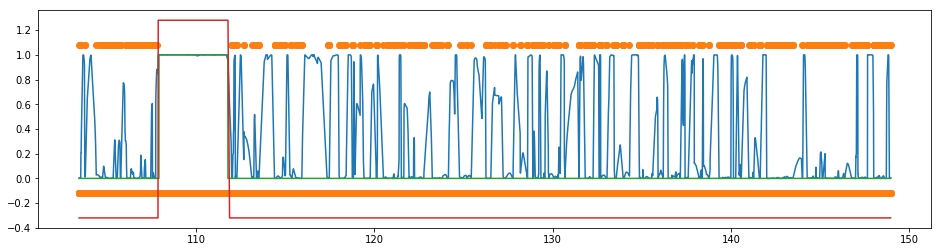

In [32]:
daRange = numpy.arange(18000,28000)
plt.figure(figsize=(16,4))
plt.plot (recoMap[daRange]*100, 1-numpy.exp(posterior[daRange]),
          recoMap[daRange]*100, (hets[daRange]-0.1)*1.2, "o",
          recoMap[daRange]*100, (1-smoothHets[daRange])>0.967,
          recoMap[daRange]*100, (truth[daRange]-0.2)*1.6)